In [11]:
import _init_paths
from loaders.dataloader import DataLoader
from opt import parse_opt
from pprint import pprint
import argparse
import os
import os.path as osp
import json
import time
import random
import h5py
from layers.match import AdaptiveReconstruct
import torch
import numpy

In [2]:
# Train Data

In [3]:
parser = argparse.ArgumentParser()
# Data input settings
parser.add_argument('--dataset', type=str, default='refcoco', help='name of dataset')
parser.add_argument('--splitBy', type=str, default='unc', help='who splits this dataset')
parser.add_argument('--start_from', type=str, default=None, help='continuing training from saved model')
# FRCN setting
parser.add_argument('--imdb_name', default='coco_minus_refer', help='image databased trained on.')
parser.add_argument('--net_name', default='res101', help='net_name: res101 or vgg16')
parser.add_argument('--iters', default=1250000, type=int, help='iterations we trained for faster R-CNN')
parser.add_argument('--tag', default='notime', help='on default tf, don\'t change this!')
parser.add_argument('--vis_feats_type', type=str, default='res101', help='visual features type: vgg16 or res101')
# Visual Encoder Setting
parser.add_argument('--visual_sample_ratio', type=float, default=0.3, help='ratio of same-type objects over different-type objects')
parser.add_argument('--visual_fuse_mode', type=str, default='concat', help='concat or mul')
parser.add_argument('--visual_init_norm', type=float, default=20, help='norm of each visual representation')
parser.add_argument('--visual_use_bn', type=int, default=-1, help='>0: use bn, -1: do not use bn in visual layer')    
parser.add_argument('--visual_use_cxt', type=int, default=1, help='if we use contxt')
parser.add_argument('--visual_cxt_type', type=str, default='frcn', help='frcn or res101')
parser.add_argument('--visual_drop_out', type=float, default=0.2, help='dropout on visual encoder')
parser.add_argument('--window_scale', type=float, default=2.5, help='visual context type')
# Visual Feats Setting
parser.add_argument('--with_st', type=int, default=1, help='if incorporating same-type objects as contexts')
parser.add_argument('--num_cxt', type=int, default=5, help='how many surrounding objects do we use')
# Language Encoder Setting
parser.add_argument('--word_embedding_size', type=int, default=512, help='the encoding size of each token')
parser.add_argument('--word_vec_size', type=int, default=512, help='further non-linear of word embedding')
parser.add_argument('--word_drop_out', type=float, default=0.5, help='word drop out after embedding')
parser.add_argument('--bidirectional', type=int, default=1, help='bi-rnn')
parser.add_argument('--rnn_hidden_size', type=int, default=512, help='hidden size of LSTM')
parser.add_argument('--rnn_type', type=str, default='lstm', help='rnn, gru or lstm')
parser.add_argument('--rnn_drop_out', type=float, default=0.2, help='dropout between stacked rnn layers')
parser.add_argument('--rnn_num_layers', type=int, default=1, help='number of layers in lang_encoder')
parser.add_argument('--variable_lengths', type=int, default=1, help='use variable length to encode') 
# Joint Embedding setting
parser.add_argument('--jemb_drop_out', type=float, default=0.1, help='dropout in the joint embedding')
parser.add_argument('--jemb_dim', type=int, default=512, help='joint embedding layer dimension')
# Reconstruct Settings
parser.add_argument('--decode_bidirectional', type=int, default=0, help='whther to use bidirection LSTM in reconstrcution')
# Loss Setting
parser.add_argument('--att_weight', type=float, default=1.0, help='weight on attribute prediction')
parser.add_argument('--visual_rank_weight', type=float, default=1.0, help='weight on paired (ref, sent) over unpaired (neg_ref, sent)')
parser.add_argument('--lang_rank_weight', type=float, default=1.0, help='weight on paired (ref, sent) over unpaired (ref, neg_sent)')
parser.add_argument('--margin', type=float, default=0.1, help='margin for ranking loss')
parser.add_argument('--lang_res_weight', type=float, default=1.0, help='weight on language reconstruction loss')
parser.add_argument('--vis_res_weight', type=float, default=0.01, help='weight on visual reconstruction loss')
parser.add_argument('--att_res_weight', type=float, default=1.0, help='weight on attribute reconstruction loss')
parser.add_argument('--loss_combined', type=float, default=5.0, help='weight on loss_combined')
parser.add_argument('--loss_divided', type=float, default=1.0, help='weight on loss_divided' )
# Optimization: General
parser.add_argument('--max_iters', type=int, default=30000, help='max number of iterations to run')
parser.add_argument('--sample_ratio', type=float, default=0.3, help='ratio of same-type objects over different-type objects')
parser.add_argument('--batch_size', type=int, default=5, help='batch size in number of images per batch')
parser.add_argument('--grad_clip', type=float, default=0.1, help='clip gradients at this value')
parser.add_argument('--seq_per_ref', type=int, default=3, help='number of expressions per object during training')
parser.add_argument('--learning_rate_decay_start', type=int, default=8000, help='at what iter to start decaying learning rate')
parser.add_argument('--learning_rate_decay_every', type=int, default=8000, help='every how many iters thereafter to drop LR by half')
parser.add_argument('--optim_epsilon', type=float, default=1e-8, help='epsilon that goes into denominator for smoothing')
parser.add_argument('--learning_rate', type=float, default=4e-4, help='learning rate')
parser.add_argument('--optim_alpha', type=float, default=0.8, help='alpha for adam')
parser.add_argument('--optim_beta', type=float, default=0.999, help='beta used for adam')
parser.add_argument('--weight_decay', type=float, default=0.0005, help='weight decay for adam')
# Evaluation/Checkpointing
parser.add_argument('--num_sents', type=int, default=-1, help='how many images to use when periodically evaluating the validation loss? (-1 = all)')
parser.add_argument('--save_checkpoint_every', type=int, default=2000, help='how often to save a model checkpoint?')
parser.add_argument('--checkpoint_path', type=str, default='output', help='directory to save models')   
parser.add_argument('--language_eval', type=int, default=0, help='Evaluate language as well (1 = yes, 0 = no)?')
parser.add_argument('--losses_log_every', type=int, default=25, help='How often do we snapshot losses, for inclusion in the progress dump? (0 = disable)')
parser.add_argument('--load_best_score', type=int, default=1, help='Do we load previous best score when resuming training.')      
parser.add_argument('--use_IoU', type=int, default=1, help='Whether to use IoU evaluation or not')
# misc
parser.add_argument('--id', type=str, default='mrcn_cmr_with_st', help='an id identifying this run/job.')
parser.add_argument('--seed', type=int, default=24, help='random number generator seed to use')
parser.add_argument('--gpuid', type=int, default=0, help='which gpu to use, -1 = use CPU')
parser.add_argument('--exp_id', type=str, default='', help='experiment id')

args = parser.parse_args(args=[])
opt = vars(args)
pprint(opt)

{'att_res_weight': 1.0,
 'att_weight': 1.0,
 'batch_size': 5,
 'bidirectional': 1,
 'checkpoint_path': 'output',
 'dataset': 'refcoco',
 'decode_bidirectional': 0,
 'exp_id': '',
 'gpuid': 0,
 'grad_clip': 0.1,
 'id': 'mrcn_cmr_with_st',
 'imdb_name': 'coco_minus_refer',
 'iters': 1250000,
 'jemb_dim': 512,
 'jemb_drop_out': 0.1,
 'lang_rank_weight': 1.0,
 'lang_res_weight': 1.0,
 'language_eval': 0,
 'learning_rate': 0.0004,
 'learning_rate_decay_every': 8000,
 'learning_rate_decay_start': 8000,
 'load_best_score': 1,
 'loss_combined': 5.0,
 'loss_divided': 1.0,
 'losses_log_every': 25,
 'margin': 0.1,
 'max_iters': 30000,
 'net_name': 'res101',
 'num_cxt': 5,
 'num_sents': -1,
 'optim_alpha': 0.8,
 'optim_beta': 0.999,
 'optim_epsilon': 1e-08,
 'rnn_drop_out': 0.2,
 'rnn_hidden_size': 512,
 'rnn_num_layers': 1,
 'rnn_type': 'lstm',
 'sample_ratio': 0.3,
 'save_checkpoint_every': 2000,
 'seed': 24,
 'seq_per_ref': 3,
 'splitBy': 'unc',
 'start_from': None,
 'tag': 'notime',
 'use_IoU'

In [4]:
opt['dataset_splitBy'] = opt['dataset'] + '_' + opt['splitBy']
data_json = osp.join('../cache/prepro', opt['dataset_splitBy'], 'data.json')
data_h5 = osp.join('../cache/prepro', opt['dataset_splitBy'], 'data.h5')
loader = DataLoader(data_h5=data_h5, data_json=data_json)

Loader loading data.json:  ../cache/prepro/refcoco_unc/data.json
vocab size is  1999
object cateogry size is  80
we have 19994 images.
we have 196771 anns.
we have 50000 refs.
we have 142210 sentences.
label_length is  10
Loader loading data.h5:  ../cache/prepro/refcoco_unc/data.h5
assigned 16994 images to split train
assigned 750 images to split testB
assigned 1500 images to split val
assigned 750 images to split testA


In [5]:
feats_dir = '%s_%s_%s' % (args.net_name, args.imdb_name, args.tag)
head_feats_dir = osp.join('../cache/feats/', opt['dataset_splitBy'], 'mrcn', feats_dir)

loader.prepare_mrcn(head_feats_dir, args)

ann_feats = osp.join('../cache/feats', opt['dataset_splitBy'], 'mrcn',
                     '%s_%s_%s_ann_feats.h5' % (opt['net_name'], opt['imdb_name'], opt['tag']))
loader.loadFeats({'ann': ann_feats})

/datasets/Kranthi/Maitreya/Manish/ARN/tools/../pyutils/mask-faster-rcnn/lib/model/config.py:365: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  yaml_cfg = edict(yaml.load(f))


Using config:
{'ANCHOR_RATIOS': [0.5, 1, 2],
 'ANCHOR_SCALES': [4, 8, 16, 32],
 'DATA_DIR': '/datasets/Kranthi/Maitreya/Manish/ARN/pyutils/mask-faster-rcnn/data',
 'DATA_DIR_IMAGE': '/datasets/Kranthi/Maitreya/Manish/ARN/data/images',
 'EXP_DIR': 'res101',
 'MASK_SIZE': 14,
 'MATLAB': 'matlab',
 'MOBILENET': {'DEPTH_MULTIPLIER': 1.0,
               'FIXED_LAYERS': 5,
               'REGU_DEPTH': False,
               'WEIGHT_DECAY': 4e-05},
 'PIXEL_MEANS': array([[[102.9801, 115.9465, 122.7717]]]),
 'POOLING_ALIGN': False,
 'POOLING_MODE': 'crop',
 'POOLING_SIZE': 7,
 'RESNET': {'FIXED_BLOCKS': 1, 'MAX_POOL': False},
 'RNG_SEED': 3,
 'ROOT_DIR': '/datasets/Kranthi/Maitreya/Manish/ARN/pyutils/mask-faster-rcnn',
 'TEST': {'BBOX_REG': True,
          'HAS_RPN': True,
          'MAX_SIZE': 1000,
          'MODE': 'nms',
          'NMS': 0.3,
          'PROPOSAL_METHOD': 'gt',
          'RPN_NMS_THRESH': 0.7,
          'RPN_POST_NMS_TOP_N': 300,
          'RPN_PRE_NMS_TOP_N': 6000,
        

In [53]:
data = loader.getBatch('train', opt)

/home/kranthi/.conda/envs/pytorch_1.5_a/lib/python3.8/site-packages/torch/nn/functional.py:3289: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/home/kranthi/.conda/envs/pytorch_1.5_a/lib/python3.8/site-packages/torch/nn/functional.py:3226: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


In [23]:
print((data.keys()))

dict_keys(['labels', 'enc_labels', 'dec_labels', 'ref_ids', 'sent_ids', 'gd_ixs', 'gd_boxes', 'cxt_ann_ids', 'Feats', 'att_labels', 'select_ixs', 'bounds'])


In [49]:
print(data['ref_ids'])

[45477, 45478]


In [40]:
print(data['Feats'].keys())

dict_keys(['fc7', 'pool5', 'lfeats', 'dif_lfeats', 'cxt_fc7', 'cxt_lfeats'])


In [55]:
print(data['Feats']['cxt_fc7'].shape)

torch.Size([6, 3, 5, 2048])


In [61]:
ann_feats = osp.join('../cache/feats', opt['dataset_splitBy'], 'mrcn',
                         '%s_%s_%s_ann_feats.h5' % (opt['net_name'], opt['imdb_name'], opt['tag']))

In [62]:
ann_fts = h5py.File(ann_feats, 'r')

In [65]:
ann_fts['pool5'].shape

(196771, 1024)

In [7]:
opt['vocab_size'] = loader.vocab_size
opt['fc7_dim'] = loader.fc7_dim
opt['pool5_dim'] = loader.pool5_dim
opt['num_atts'] = loader.num_atts
model = AdaptiveReconstruct(opt).cuda()

/home/kranthi/.conda/envs/pytorch_1.5_a/lib/python3.8/site-packages/torch/nn/modules/rnn.py:47: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/home/kranthi/.conda/envs/pytorch_1.5_a/lib/python3.8/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [58]:
optimizer = torch.optim.Adam(model.parameters(),
                                 lr=opt['learning_rate'],
                                 betas=(opt['optim_alpha'], opt['optim_beta']),
                                 eps=opt['optim_epsilon'])

In [59]:
labels = data['labels']
enc_labels = data['enc_labels']
dec_labels = data['dec_labels']
Feats = data['Feats']
att_labels, select_ixs = data['att_labels'], data['select_ixs']

In [56]:
att_weights = loader.get_attribute_weights()
scores, losses,_,_,_,_,_ = model(Feats['pool5'], Feats['fc7'], Feats['lfeats'], Feats['dif_lfeats'],
                                         Feats['cxt_fc7'], Feats['cxt_lfeats'], labels, enc_labels, dec_labels, att_labels, select_ixs, att_weights)
losses['loss'].backward()
optimizer.step()

RuntimeError: Expected object of device type cuda but got device type cpu for argument #1 'self' in call to _th_index_select

In [9]:
for param in model.named_parameters():
#     if("decoder" in param[0]):
        print(param[0])


rnn_encoder.embedding.weight
rnn_encoder.mlp.0.weight
rnn_encoder.mlp.0.bias
rnn_encoder.rnn.weight_ih_l0
rnn_encoder.rnn.weight_hh_l0
rnn_encoder.rnn.bias_ih_l0
rnn_encoder.rnn.bias_hh_l0
rnn_encoder.rnn.weight_ih_l0_reverse
rnn_encoder.rnn.weight_hh_l0_reverse
rnn_encoder.rnn.bias_ih_l0_reverse
rnn_encoder.rnn.bias_hh_l0_reverse
weight_fc.weight
weight_fc.bias
sub_attn.fc.weight
sub_attn.fc.bias
loc_attn.fc.weight
loc_attn.fc.bias
rel_attn.fc.weight
rel_attn.fc.bias
sub_encoder.pool5_normalizer.weight
sub_encoder.fc7_normalizer.weight
loc_encoder.lfeats_normalizer.weight
loc_encoder.dif_lfeat_normalizer.weight
rel_encoder.vis_feat_normalizer.weight
rel_encoder.lfeat_normalizer.weight
sub_score.feat_fuse.0.weight
sub_score.feat_fuse.0.bias
sub_score.feat_fuse.2.weight
sub_score.feat_fuse.2.bias
loc_score.feat_fuse.0.weight
loc_score.feat_fuse.0.bias
loc_score.feat_fuse.2.weight
loc_score.feat_fuse.2.bias
rel_score.feat_fuse.0.weight
rel_score.feat_fuse.0.bias
rel_score.feat_fuse.2.wei

In [37]:
# Val/Test Data

In [49]:
split = 'val'

In [50]:
loader.resetIterator(split)

In [51]:
num = 0
prob_sum = 0
sent_sum = 0
ann = numpy.zeros(70)
for i in range(1500):
    data = loader.getTestBatch(split, opt)
    sents = len(data['sent_ids'])
    anns = len(data['ann_ids'])
    prob_sum += (1.0 * sents) / (1.0*anns)
    sent_sum += sents
    num += 1
    ann[anns] += 1

ann = 100.0*ann/(1.0*1500)
print(num)
print(sent_sum)
print(prob_sum/sent_sum)
print(max_ann)

/home/kranthi/.conda/envs/pytorch_1.5_a/lib/python3.8/site-packages/torch/nn/functional.py:3289: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/home/kranthi/.conda/envs/pytorch_1.5_a/lib/python3.8/site-packages/torch/nn/functional.py:3226: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


1500
10834
0.15599614186154473
47


In [52]:
import matplotlib.pyplot as plt

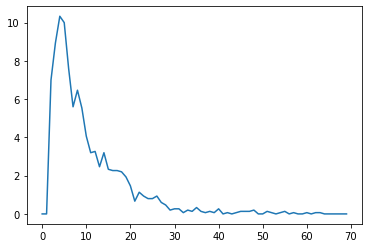

In [53]:
plt.plot(ann)

In [57]:
per = 0
for i in range(50):
    per += ann[i]
    if(per >= 50):
        print(i)
        print(per)
        break

8
55.93333333333334


In [10]:
data = loader.getTestBatch(split, opt)

/home/kranthi/.conda/envs/pytorch_1.5_a/lib/python3.8/site-packages/torch/nn/functional.py:3289: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/home/kranthi/.conda/envs/pytorch_1.5_a/lib/python3.8/site-packages/torch/nn/functional.py:3226: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


In [14]:
data['sent_ids']

[30384, 30385, 30386, 30387, 30388, 30389]

In [66]:
a = [10,20,5,30]
b = numpy.argsort(a)[:4]
print(b)

[2 0 1 3]


In [63]:
a = 3
b = 4
for i in range(10):
    print("a%s b%s"%(a,b))


a3 b4
a3 b4
a3 b4
a3 b4
a3 b4
a3 b4
a3 b4
a3 b4
a3 b4
a3 b4
